In [28]:
%pwd
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras import models, layers, metrics
from sklearn.metrics import confusion_matrix
import os
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, balanced_accuracy_score
#you need to adjust the paths until it gets properly fixed, and run the labelling script for the mobifall.

In [2]:
%pwd

'D:\\TUDarmstadt\\DSII\\workspace\\fff\\fallDetection\\software\\notebooks'

In [3]:
%cd ..

D:\TUDarmstadt\DSII\workspace\fff\fallDetection\software


In [4]:
%cd dataPreprocessing/

D:\TUDarmstadt\DSII\workspace\fff\fallDetection\software\dataPreprocessing


In [5]:
from labellingData import readSubsCsvs
from windowData import createSlidingWindows

In [6]:
%cd ..
%cd ..

D:\TUDarmstadt\DSII\workspace\fff\fallDetection\software
D:\TUDarmstadt\DSII\workspace\fff\fallDetection


In [7]:
absolutepath = 'D:/TUDarmstadt/DSII/workspace/fallDetection/dataSets/MobiFall_Dataset_v2.0_labelled\sub2'
df = readSubsCsvs(absolutepath)
df.head()

,timestamp,accelerometer_x,accelerometer_y,accelerometer_z,id,Name,Age,Height,Weight,Gender,fall
0,150850692000,0.632069,10.745177,-2.786851,2,sub2,26,169,64,Male,8
1,150870594000,0.603339,11.817780,-2.806004,2,sub2,26,169,64,Male,8
2,150880702000,1.139640,11.070788,-2.394202,2,sub2,26,169,64,Male,8
3,150892211000,1.312023,10.438720,-1.867477,2,sub2,26,169,64,Male,8
4,150903892000,1.015141,10.122685,-1.532289,2,sub2,26,169,64,Male,8


In [8]:
for col in df.columns:
    pctMissing = df[col].isnull().mean()
    print(f'{col} - {pctMissing :.1%}')

timestamp - 0.0%
accelerometer_x - 0.0%
accelerometer_y - 0.0%
accelerometer_z - 0.0%
id - 0.0%
Name - 0.0%
Age - 0.0%
Height - 0.0%
Weight - 0.0%
Gender - 0.0%
fall - 0.0%


In [9]:
df['fall'] = df['fall'].map(lambda x : 0 if x in range(1,10) else 1)
fallRaw = df["fall"]
featuresRaw = df.drop(["fall", "id", "Name", "Age", "Height", "Weight", "Gender", "timestamp"], axis = 1)

In [10]:
featuresRaw.head()

,accelerometer_x,accelerometer_y,accelerometer_z
0,0.632069,10.745177,-2.786851
1,0.603339,11.817780,-2.806004
2,1.139640,11.070788,-2.394202
3,1.312023,10.438720,-1.867477
4,1.015141,10.122685,-1.532289


In [11]:
scaler = MinMaxScaler()
numerical = ["accelerometer_x", "accelerometer_y", "accelerometer_z",]

In [12]:
featuresTransformed = pd.DataFrame(data = featuresRaw)
featuresTransformed[numerical] = scaler.fit_transform(featuresTransformed[numerical])
featuresTransformed.head()

,accelerometer_x,accelerometer_y,accelerometer_z
0,0.511605,0.772208,0.411364
1,0.510856,0.800000,0.410859
2,0.524832,0.780645,0.421717
3,0.529324,0.764268,0.435606
4,0.521587,0.756079,0.444444


In [13]:
y = fallRaw.values
labelEncoder = LabelEncoder()
yEncoded = labelEncoder.fit_transform(y)
y

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [14]:
windows, labels = createSlidingWindows(featuresTransformed.values, yEncoded, 200)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(windows, labels, test_size = 0.2, random_state = 0)
print('Training set has {} samples'.format(x_train.shape))
print('Testing set has {} samples'.format(x_test.shape))

Training set has (78551, 200, 3) samples
Testing set has (19638, 200, 3) samples


In [16]:
class_labels = np.unique(y_train)
classWeights = compute_class_weight(class_weight ='balanced', classes = class_labels, y= y_train)
classWeights
class_weight_dict = dict(zip(class_labels, classWeights))
class_weight_dict

{0: 0.5568702235959676, 1: 4.895973572675143}

In [17]:
numClasses = len(np.unique(y))
y_trainCat = to_categorical(y_train, num_classes=numClasses)
y_testCat = to_categorical(y_test, num_classes=numClasses)
y_trainCat.shape

(78551, 2)

In [18]:
input = (200, 3)
model = models.Sequential()
model.add(layers.Conv1D(6, kernel_size=4, activation='relu', input_shape=input, padding='same'))

model.add(layers.BatchNormalization())

model.add(layers.MaxPooling1D(pool_size=4, strides=4))

model.add(layers.Conv1D(12, kernel_size=4, activation='relu',padding='same'))

model.add(layers.BatchNormalization())

model.add(layers.MaxPooling1D(pool_size=4, strides=4))
model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.3))
model.add(layers.Dense(numClasses, activation='softmax'))


In [19]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', metrics.AUC()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 200, 6)            78        
                                                                 
 batch_normalization (BatchN  (None, 200, 6)           24        
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 6)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 12)            300       
                                                                 
 batch_normalization_1 (Batc  (None, 50, 12)           48        
 hNormalization)                                                 
                                                        

In [20]:
batch = 64
epochs = 10
#iterationsPerEp = 100

In [21]:
model.fit(x_train, y_trainCat, batch_size=batch, epochs=epochs, class_weight= class_weight_dict)#, steps_per_epoch=iterationsPerEp)

Epoch 1/10
1228/1228 [==============================] - 55s 44ms/step - loss: 0.0879 - accuracy: 0.9624 - auc: 0.9889
Epoch 2/10
1228/1228 [==============================] - 55s 45ms/step - loss: 0.0185 - accuracy: 0.9930 - auc: 0.9991
Epoch 3/10
1228/1228 [==============================] - 56s 45ms/step - loss: 0.0100 - accuracy: 0.9966 - auc: 0.9995
Epoch 4/10
1228/1228 [==============================] - 50s 41ms/step - loss: 0.0073 - accuracy: 0.9976 - auc: 0.9997
Epoch 5/10
1228/1228 [==============================] - 54s 44ms/step - loss: 0.0082 - accuracy: 0.9974 - auc: 0.9996
Epoch 6/10
1228/1228 [==============================] - 55s 45ms/step - loss: 0.0054 - accuracy: 0.9982 - auc: 0.9997
Epoch 7/10
1228/1228 [==============================] - 52s 43ms/step - loss: 0.0034 - accuracy: 0.9989 - auc: 0.9999
Epoch 8/10
1228/1228 [==============================] - 57s 46ms/step - loss: 0.0047 - accuracy: 0.9988 - auc: 0.9997
Epoch 9/10
1228/1228 [==============================] - 

In [ ]:
# classDist = fallRaw.value_counts()
# total = len(df)
# percentage_distribution = (classDist / total) * 100

# plt.figure(figsize= [10,10])
# plt.pie(percentage_distribution, labels=percentage_distribution.index, autopct='%1.1f%%', startangle=90)
# plt.title('Class Distribution Percentage')
# plt.show()

In [23]:
predictions = model.predict(x_test)
predictions.shape

614/614 [==============================] - 2s 3ms/step


(19638, 2)

In [24]:
yTrueClasses = y_test
yPredClasses = np.argmax(predictions, axis=1)
confMat = confusion_matrix(yTrueClasses, yPredClasses)
confMat

array([[17557,    96],
       [    0,  1985]], dtype=int64)

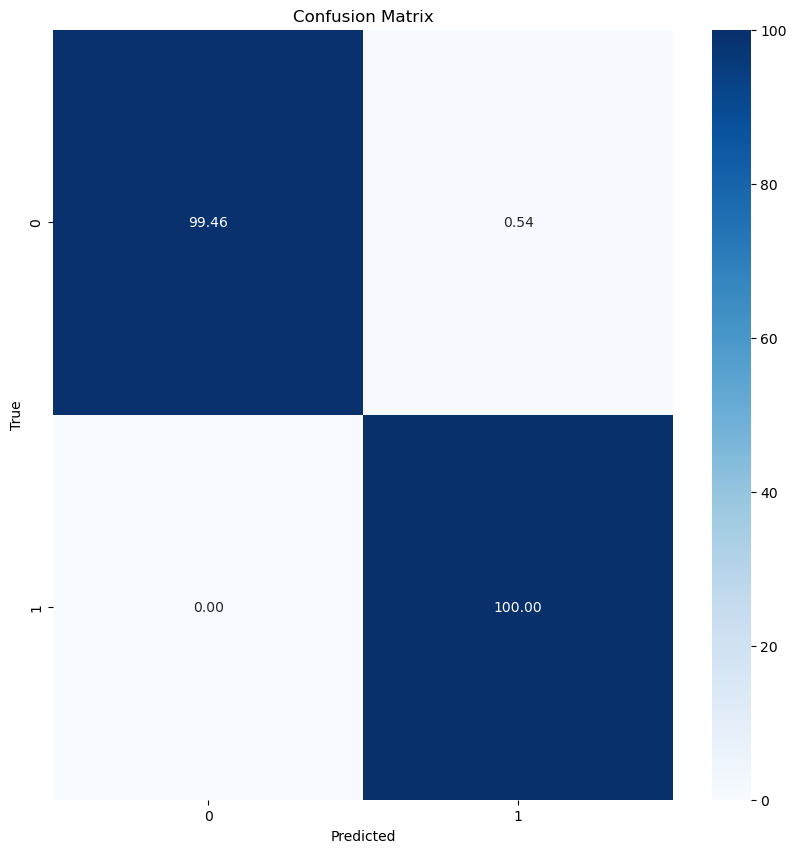

In [25]:
classes = ['0', '1']
plt.figure(figsize=[10,10])
confMatPerc = confMat.astype('float') / confMat.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(confMatPerc , annot=True, fmt='0.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [26]:
aucScore = roc_auc_score(yTrueClasses, yPredClasses)
aucScore

0.9972809154251402

In [27]:
f1 = f1_score(yTrueClasses, yPredClasses)
f1

0.9763895720609936

In [29]:
bacc = balanced_accuracy_score(yTrueClasses, yPredClasses)
bacc

0.9972809154251402